In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
from dotenv import load_dotenv
import os

env_path = '../../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
today

datetime.datetime(2024, 11, 12, 20, 42, 10, 481624)

In [3]:
project = hopsworks.login(project='AMomozZz')
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163416
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="aq_xgboost_model",
    version=1,
)
weather_fg = fs.get_feature_group(
    name='new_w',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='new_aq',
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.53242E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float'...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
batch_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by=['date'], ascending=True, ignore_index=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_11,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20
0,2024-11-13 00:00:00+00:00,17.400000,0.0,7.862518,105.945465,shanghai,144.0,132.0,56.0,46.0,...,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0
1,2024-11-14 00:00:00+00:00,20.500000,0.0,7.421590,129.093857,shanghai,NaN,144.0,132.0,56.0,...,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0
2,2024-11-15 00:00:00+00:00,20.299999,0.1,7.771331,103.392517,shanghai,NaN,NaN,144.0,132.0,...,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0
3,2024-11-16 00:00:00+00:00,20.500000,0.0,11.966953,6.911131,shanghai,NaN,NaN,NaN,144.0,...,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0
4,2024-11-17 00:00:00+00:00,13.300000,0.0,22.881956,12.724360,shanghai,NaN,NaN,NaN,NaN,...,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0
5,2024-11-18 00:00:00+00:00,11.600000,0.0,22.539564,26.564985,shanghai,NaN,NaN,NaN,NaN,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0
6,2024-11-19 00:00:00+00:00,10.950000,0.0,12.261158,3.366400,shanghai,NaN,NaN,NaN,NaN,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0
7,2024-11-20 00:00:00+00:00,12.050000,0.0,6.696387,53.746078,shanghai,NaN,NaN,NaN,NaN,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0
8,2024-11-21 00:00:00+00:00,13.000000,0.0,6.989935,348.111359,shanghai,NaN,NaN,NaN,NaN,...,56.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0


In [7]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_yesterday"]])

l = []
for i in weather_fg.features:
    if i.name != 'date' and i.name != 'city':
        l.append(i.name)

batch_data['predicted_pm25'] = None

for i in range(0, len(batch_data)):
    p = retrieved_xgboost_model.predict(batch_data.iloc[[i]][l])[0]
    batch_data.at[i, 'predicted_pm25'] = p
    index = 1
    for j in range(i+1, batch_data.shape[0]):
        batch_data.at[j, f"pm25_{index}"] = p
        index += 1

display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25
0,2024-11-13 00:00:00+00:00,17.400000,0.0,7.862518,105.945465,shanghai,144.000000,132.000000,56.000000,46.000000,...,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,46.0,147.276321
1,2024-11-14 00:00:00+00:00,20.500000,0.0,7.421590,129.093857,shanghai,147.276321,144.000000,132.000000,56.000000,...,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,114.631012
2,2024-11-15 00:00:00+00:00,20.299999,0.1,7.771331,103.392517,shanghai,114.631012,147.276321,144.000000,132.000000,...,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,107.263954
3,2024-11-16 00:00:00+00:00,20.500000,0.0,11.966953,6.911131,shanghai,107.263954,114.631012,147.276321,144.000000,...,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,111.496017
4,2024-11-17 00:00:00+00:00,13.300000,0.0,22.881956,12.724360,shanghai,111.496017,107.263954,114.631012,147.276321,...,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,75.706985
5,2024-11-18 00:00:00+00:00,11.600000,0.0,22.539564,26.564985,shanghai,75.706985,111.496017,107.263954,114.631012,...,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,74.411118
6,2024-11-19 00:00:00+00:00,10.950000,0.0,12.261158,3.366400,shanghai,74.411118,75.706985,111.496017,107.263954,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,109.740265
7,2024-11-20 00:00:00+00:00,12.050000,0.0,6.696387,53.746078,shanghai,109.740265,74.411118,75.706985,111.496017,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,121.396072
8,2024-11-21 00:00:00+00:00,13.000000,0.0,6.989935,348.111359,shanghai,121.396072,109.740265,74.411118,75.706985,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,159.938187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

In [8]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-13 00:00:00+00:00,17.400000,0.0,7.862518,105.945465,shanghai,144.000000,132.000000,56.000000,46.000000,...,49.0,115.0,34.0,23.0,47.0,46.0,147.276321,jinganjiancezhan,china,1
1,2024-11-14 00:00:00+00:00,20.500000,0.0,7.421590,129.093857,shanghai,147.276321,144.000000,132.000000,56.000000,...,54.0,49.0,115.0,34.0,23.0,47.0,114.631012,jinganjiancezhan,china,2
2,2024-11-15 00:00:00+00:00,20.299999,0.1,7.771331,103.392517,shanghai,114.631012,147.276321,144.000000,132.000000,...,49.0,54.0,49.0,115.0,34.0,23.0,107.263954,jinganjiancezhan,china,3
3,2024-11-16 00:00:00+00:00,20.500000,0.0,11.966953,6.911131,shanghai,107.263954,114.631012,147.276321,144.000000,...,20.0,49.0,54.0,49.0,115.0,34.0,111.496017,jinganjiancezhan,china,4
4,2024-11-17 00:00:00+00:00,13.300000,0.0,22.881956,12.724360,shanghai,111.496017,107.263954,114.631012,147.276321,...,103.0,20.0,49.0,54.0,49.0,115.0,75.706985,jinganjiancezhan,china,5
5,2024-11-18 00:00:00+00:00,11.600000,0.0,22.539564,26.564985,shanghai,75.706985,111.496017,107.263954,114.631012,...,140.0,103.0,20.0,49.0,54.0,49.0,74.411118,jinganjiancezhan,china,6
6,2024-11-19 00:00:00+00:00,10.950000,0.0,12.261158,3.366400,shanghai,74.411118,75.706985,111.496017,107.263954,...,124.0,140.0,103.0,20.0,49.0,54.0,109.740265,jinganjiancezhan,china,7
7,2024-11-20 00:00:00+00:00,12.050000,0.0,6.696387,53.746078,shanghai,109.740265,74.411118,75.706985,111.496017,...,45.0,124.0,140.0,103.0,20.0,49.0,121.396072,jinganjiancezhan,china,8
8,2024-11-21 00:00:00+00:00,13.000000,0.0,6.989935,348.111359,shanghai,121.396072,109.740265,74.411118,75.706985,...,35.0,45.0,124.0,140.0,103.0,20.0,159.938187,jinganjiancezhan,china,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

2024-11-12 20:42:20,775 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



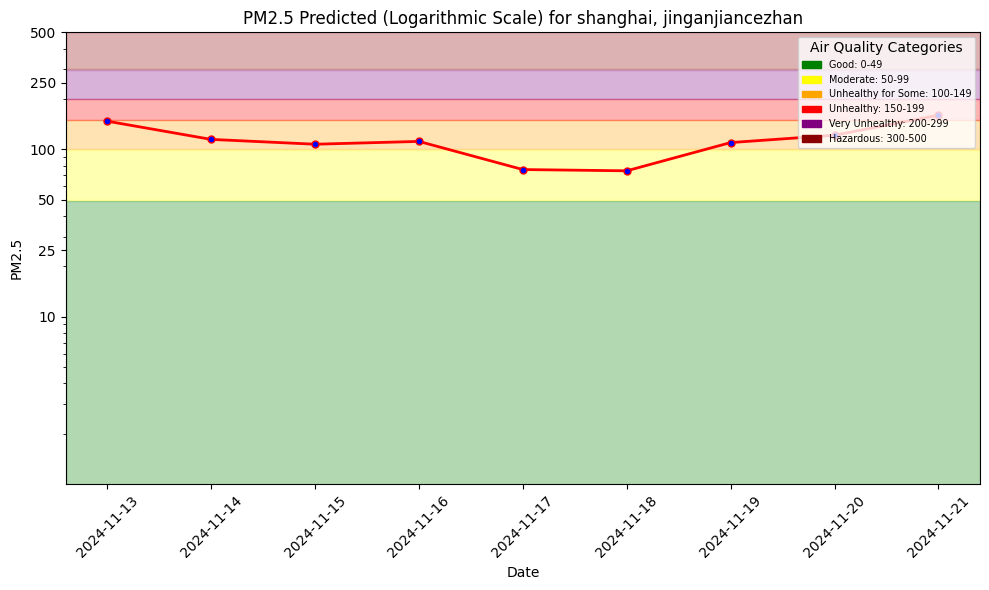

In [9]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [10]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [11]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163416/jobs/named/aq_predictions_3_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1c0159c2410>, None)

In [12]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 


In [13]:
display(monitor_fg.read().sort_values(by=['date'], ascending=True))
display(monitoring_df)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25,street,country,days_before_forecast_day
9,2024-11-12 00:00:00+00:00,16.750000,0.0,7.145796,49.085716,shanghai,132.000000,56.000000,46.000000,55.000000,...,115.0,34.0,23.0,47.0,46.0,95.0,108.817917,jinganjiancezhan,china,1
5,2024-11-13 00:00:00+00:00,17.400000,0.0,7.862518,105.945465,shanghai,144.000000,132.000000,56.000000,46.000000,...,49.0,115.0,34.0,23.0,47.0,46.0,147.276321,jinganjiancezhan,china,1
3,2024-11-14 00:00:00+00:00,20.500000,0.0,7.421590,129.093857,shanghai,147.276321,144.000000,132.000000,56.000000,...,54.0,49.0,115.0,34.0,23.0,47.0,114.631012,jinganjiancezhan,china,2
0,2024-11-15 00:00:00+00:00,20.299999,0.1,7.771331,103.392517,shanghai,114.631012,147.276321,144.000000,132.000000,...,49.0,54.0,49.0,115.0,34.0,23.0,107.263954,jinganjiancezhan,china,3
7,2024-11-16 00:00:00+00:00,20.500000,0.0,11.966953,6.911131,shanghai,107.263954,114.631012,147.276321,144.000000,...,20.0,49.0,54.0,49.0,115.0,34.0,111.496017,jinganjiancezhan,china,4
8,2024-11-17 00:00:00+00:00,13.300000,0.0,22.881956,12.724360,shanghai,111.496017,107.263954,114.631012,147.276321,...,103.0,20.0,49.0,54.0,49.0,115.0,75.706985,jinganjiancezhan,china,5
4,2024-11-18 00:00:00+00:00,11.600000,0.0,22.539564,26.564985,shanghai,75.706985,111.496017,107.263954,114.631012,...,140.0,103.0,20.0,49.0,54.0,49.0,74.411118,jinganjiancezhan,china,6
2,2024-11-19 00:00:00+00:00,10.950000,0.0,12.261158,3.366400,shanghai,74.411118,75.706985,111.496017,107.263954,...,124.0,140.0,103.0,20.0,49.0,54.0,109.740265,jinganjiancezhan,china,7
1,2024-11-20 00:00:00+00:00,12.050000,0.0,6.696387,53.746078,shanghai,109.740265,74.411118,75.706985,111.496017,...,45.0,124.0,140.0,103.0,20.0,49.0,121.396072,jinganjiancezhan,china,8
6,2024-11-21 00:00:00+00:00,13.000000,0.0,6.989935,348.111359,shanghai,121.396072,109.740265,74.411118,75.706985,...,35.0,45.0,124.0,140.0,103.0,20.0,159.938187,jinganjiancezhan,china,9


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-13 00:00:00+00:00,17.40,0.0,7.862518,105.945465,shanghai,144.0,132.0,56.0,46.0,...,49.0,115.0,34.0,23.0,47.0,46.0,147.276321,jinganjiancezhan,china,1
1,2024-11-12 00:00:00+00:00,16.75,0.0,7.145796,49.085716,shanghai,132.0,56.0,46.0,55.0,...,115.0,34.0,23.0,47.0,46.0,95.0,108.817917,jinganjiancezhan,china,1


In [14]:
air_quality_df = air_quality_fg.read()
air_quality_fg.read().sort_values(by=['date'], ascending=True).tail(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,date,pm25,country,city,street,url
3121,2024-11-08 00:00:00+00:00,55.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
2555,2024-11-09 00:00:00+00:00,46.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3039,2024-11-10 00:00:00+00:00,56.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3952,2024-11-11 00:00:00+00:00,132.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3953,2024-11-12 00:00:00+00:00,144.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486


In [15]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-12 00:00:00+00:00,108.817917,144.0


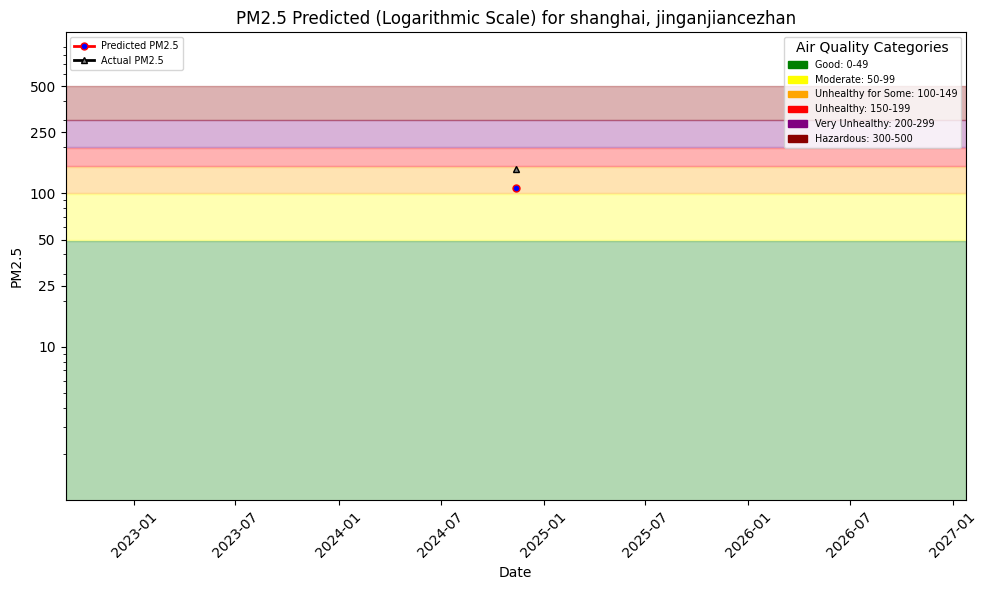

In [16]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()